<a href="https://colab.research.google.com/github/aaronmat1905/MLdiaries/blob/main/Deep%20Learning/AE_AutoEncoders/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Source Inspired from material available on Internet, AI and particularly*
- https://avandekleut.github.io/vae/

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200

# **AutoEncoders**
*The Basics*

> **Autoencoders** are **neural networks** that learn to **compress data** into a **smaller form**, and then **reconstruct** it, capturing essential patterns in the process.

It is then trained to minimize the **Reconstruction Error** → *The Error between the original Input and the reconstructed Input*

**Main Components of the AutoEncoder**:
1. Encoder
> Encoder Compresses the data into a compact representation → **Latent Space**
2. Decoder
> Decoder Reconstructs the original data from the compact representation

By the end of the training process, the model can understand which details/features are important to keep and which could be left out.
___
**Mathematically**,

$$
  Z= f(w_e.x + b_e)
$$
Where, `Z` is the Lower dimension representation, `{w_e and b_e}` are the encoder weight and bias.

And,
$$
  X'=f(w_d.Z+b_d)
$$
Where `X'` is the Reconstructed input vector, and the rest are decoder weights and bias.
___
**Notes**
- AE can learn non-linear representation of data
- It is not-interpretable
- It is self-supervised/unsupervised, so we use it for **Classification or Regression**
- Latent Space Dimensionality is always lesser than or equal to the Inpur vector dimensionality

> **Technically, we predict input from input**

**Applications**
- Image Inpainting [Filling in the missing parts of an image]
- Image Sorting [Breaking the image into parts and then, sorting them correctly]

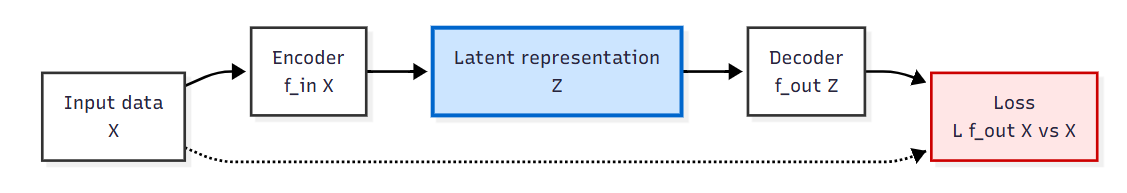

### **Encoder**

In [3]:
# nn.Module is a base class for all Neural Network modules in PyTorch

class Encoder(nn.Module):
  def __init__(self, latent_dims):
    super(Encoder, self).__init__() # Calls the constructor of the parent class nn.Module
    self.linear1 = nn.Linear(784, 512) # Maps the input from 784 dimensions to 512 dimensions
    self.linear2 = nn.Linear(512, latent_dims) # Maps the 512-dimensional input to latent_dims (Size of the compressed representation)
  def forward(self, x):
    # Sequence of computations applied to the input tensor
    x = torch.flatten(x, start_dim=1) # Flattens each image into a single vector of length 784 keeping batch dimension intact
    x = F.relu(self.linear1(x)) # Flattened vector first passed through self.linear1 followed by Relu activation function
    return self.linear2(x) # Final output is the latent representation, to be used by the decoder or for tasks like clustering

### **Decoder**

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

### **AutoEncoder (AE)**

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder(latent_dims)
    self.decoder = Decoder(latent_dims)
  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

### Training

In [6]:
device

'cuda'

In [7]:
def train(autoencoder, data, epochs=20):
  opt = torch.optim.Adam(autoencoder.parameters()) # Initialize an Adam Optimizer from the PyTorch Deep Learning Library
  for epoch in range(epochs):
    for x, _ in data:
      x = x.to(device) # GPU
      opt.zero_grad() # Reset the gradients of all parameters to zero
      x_pred = autoencoder(x)
      loss = ((x-x_pred)**2).sum()
      loss.backward()
      opt.step() # Update the parameters using new gradients
    print(f"Epoch {epoch+1}/{epochs} completed. Last Batch Loss: {loss.item():.4f}")
  return autoencoder

Inferencing:

In [8]:
latent_dims = 2
autoencoder = AutoEncoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.49MB/s]


Epoch 1/20 completed. Last Batch Loss: 3827.0425
Epoch 2/20 completed. Last Batch Loss: 3463.9800
Epoch 3/20 completed. Last Batch Loss: 3375.5391
Epoch 4/20 completed. Last Batch Loss: 3226.9937
Epoch 5/20 completed. Last Batch Loss: 3249.6177
Epoch 6/20 completed. Last Batch Loss: 3047.4175
Epoch 7/20 completed. Last Batch Loss: 3165.5171
Epoch 8/20 completed. Last Batch Loss: 3177.6091
Epoch 9/20 completed. Last Batch Loss: 3157.6528
Epoch 10/20 completed. Last Batch Loss: 3058.4995
Epoch 11/20 completed. Last Batch Loss: 3050.7380
Epoch 12/20 completed. Last Batch Loss: 2964.0215
Epoch 13/20 completed. Last Batch Loss: 3466.4114
Epoch 14/20 completed. Last Batch Loss: 2922.2119
Epoch 15/20 completed. Last Batch Loss: 3110.5305
Epoch 16/20 completed. Last Batch Loss: 2705.1338
Epoch 17/20 completed. Last Batch Loss: 2948.8696
Epoch 18/20 completed. Last Batch Loss: 3240.1526
Epoch 19/20 completed. Last Batch Loss: 3047.7898
Epoch 20/20 completed. Last Batch Loss: 2919.1873


In [9]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

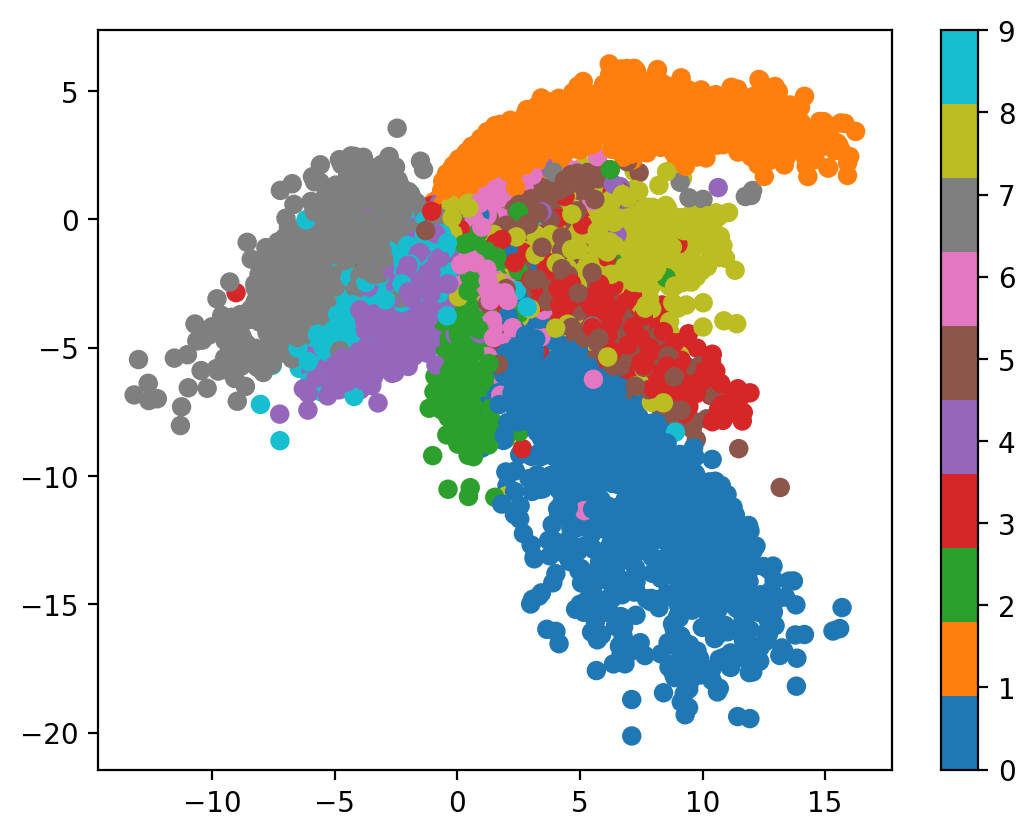

In [10]:
plot_latent(autoencoder, data)

In [11]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

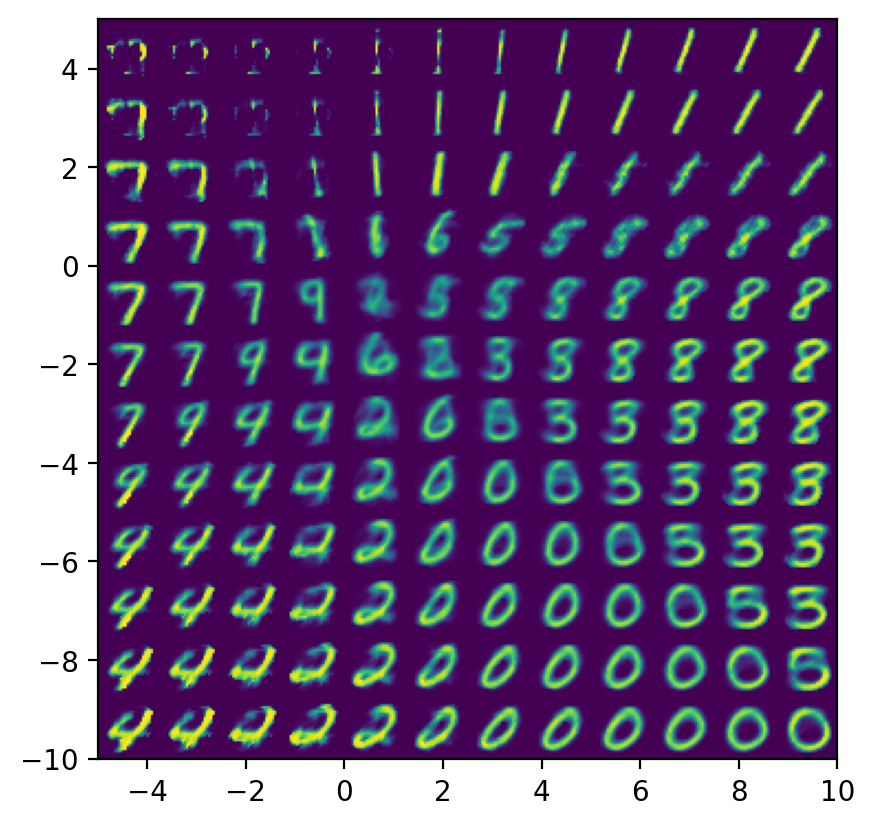

In [12]:
plot_reconstructed(autoencoder)